This notebook demonstrates how to obtain the statistics within a raster using our superpixel segments. This is done with scipy's `ndimage`, which provides a fast API to do so.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from pathlib import Path
import scipy.ndimage.measurements as measurements
from rscube import (apply_func_to_superpixels,
                    get_array_from_features,
                    get_superpixel_means_as_features,
                    get_superpixel_stds_as_features)
from tqdm import tqdm
from itertools import starmap

# Opening the Rasters

Let's set a path up for our "datacube", i.e. our co-registered rasters.

In [2]:
DATA_DIR = Path('data/datacube_ROI')
DATA_DIR.exists()

True

We have a function to open the first band of a GeoTiff.

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    return arr

We have the 4 hansen images (Landsat 3, 4, 5, 7) and open them so we have a list of numpy arrays.

In [4]:
hansen_paths = sorted(list(DATA_DIR.glob('hansen*.tif')))
hansen_arrs = list(map(open_one, tqdm(hansen_paths)))

100%|██████████| 4/4 [00:00<00:00, 40.14it/s]


Similarly, we have a list of arrays corresponding to 3 polarizations of alos images HH, HV, VV (in alphabetical order).

In [5]:
alos_paths = sorted(list(DATA_DIR.glob('ALOS*.tif')))
alos_arrs = list(map(open_one, tqdm(alos_paths)))

100%|██████████| 3/3 [00:00<00:00, 45.78it/s]


# Opening the Superpixels

We open the arrays of label where each pixel is assigned the label of its respective label.

In [6]:
with rasterio.open('out/superpixels.tif') as ds:
    superpixel_labels = ds.read(1)
    profile = ds.profile

profile['dtype'] = 'float32'
profile['nodata'] = np.nan

# Aggregating the Raster Data within a Superpixel Segment


## Getting the Features

We obtain features for each superpixel, which provide us away to match each segment with its aggregated statistic. We call them "features" because these can be directly used with [`sklearn`](https://scikit-learn.org/stable/)'s API.

Each feature array is of the form features $K \times 1$ where $K$ are the number of superpixels segments. Skimage and our earlier bookkeeping ensures that are labels are of the form 0, 1, 2, ... K, so that each index of the mean feature is also its label, which makes subsequent lookup very fast.

We first define a "partial" function (more formally, this is known as a [partial application](https://en.wikipedia.org/wiki/Partial_application)) in which we fix the labels according to those found in the previous notebook and only determine features with respect to an image.

In [7]:
def get_superpixel_means_as_features_partial(img):
    return get_superpixel_means_as_features(superpixel_labels, img)

hansen_mean_features = list(map(get_superpixel_means_as_features_partial, tqdm(hansen_arrs)))
hansen_std_features = list(map(get_superpixel_means_as_features_partial, tqdm(hansen_arrs)))

100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Let's take a step back and understand what these "features" mean. Again, we have a feature corresponding to each label.

In [8]:
# The number of label x 1
hansen_mean_features[0].shape

(59223, 1)

We have 0 as our mask label and then `1, ..., number of labels - 1`, which is indeed the case.

In [9]:
# The maximum should be precicesely the number of labels - 1 (because we also have the mask)
superpixel_labels.max()

59222

Let's consider an arbitrary label and make sure that it's feature is the mean.

In [10]:
label_to_inspect = 31

In [11]:
hansen_3 = hansen_arrs[0]
hansen_3[superpixel_labels==label_to_inspect].mean()

20.05

In [12]:
hansen_3_mean_f = hansen_mean_features[0]
hansen_3_mean_f[label_to_inspect]

array([20.05])

Let's now do the same for alos.

In [13]:
alos_mean_features = list(map(get_superpixel_means_as_features_partial, tqdm(alos_arrs)))
alos_std_features = list(map(get_superpixel_means_as_features_partial, tqdm(alos_arrs)))

100%|██████████| 3/3 [00:00<00:00,  6.63it/s]


## Aggregating statistics within a superpixel

In [14]:
def get_array_from_features_partial(features):
    arr = get_array_from_features(superpixel_labels, features)
    return arr

In [15]:
hansen_mean_arrs = list(map(get_array_from_features_partial, tqdm(hansen_mean_features)))
hansen_std_arrs = list(map(get_array_from_features_partial, tqdm(hansen_std_features)))

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


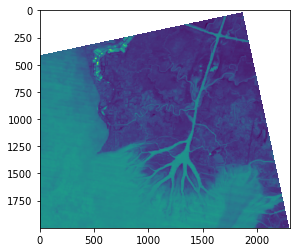

In [16]:
plt.imshow(hansen_mean_arrs[0])

In [17]:
alos_mean_arrs = list(map(get_array_from_features_partial, tqdm(alos_mean_features)))
alos_std_arrs = list(map(get_array_from_features_partial, tqdm(alos_std_features)))

100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


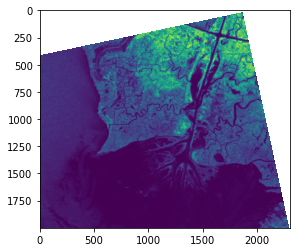

In [18]:
plt.imshow(alos_mean_arrs[0])

# Writing The Aggregated Arrays

First, we write a function to write an image according to a specified shapefile. Note the metadata `profile` is determined from one of the alos image above.

In [19]:
def write_one(arr, dest_path):
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(arr.astype(np.float32), 1)
    return dest_path

In [20]:
dest_dir = Path('out/aggregated_superpixel_statistics_rasters')
dest_dir.mkdir(exist_ok=True, parents=True)

### Hansen Data

In [21]:
dest_paths = [dest_dir/f'hansen_mean_{k}.tif' for k in [3, 4, 5, 7]]
list(starmap(write_one, zip(hansen_mean_arrs, tqdm(dest_paths))))

 75%|███████▌  | 3/4 [00:00<00:00,  6.86it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_3.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_4.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_5.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_7.tif')]

In [22]:
dest_paths = [dest_dir/f'hansen_std_{k}.tif' for k in [3, 4, 5, 7]]
list(starmap(write_one, zip(hansen_mean_arrs, tqdm(dest_paths))))

 75%|███████▌  | 3/4 [00:00<00:00,  6.82it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_3.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_4.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_5.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_7.tif')]

### ALOS Data

In [23]:
dest_paths = [dest_dir/f'alos_{pol}_mean.tif' for pol in ['hh', 'hv', 'vv']]
list(starmap(write_one, zip(alos_mean_arrs, tqdm(dest_paths))))

 67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/alos_hh_mean.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/alos_hv_mean.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/alos_vv_mean.tif')]

In [24]:
dest_paths = [dest_dir/f'alos_{pol}_std.tif' for pol in ['hh', 'hv', 'vv']]
list(starmap(write_one, zip(tqdm(alos_std_arrs), dest_paths)))

100%|██████████| 3/3 [00:00<00:00,  9.06it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/alos_hh_std.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/alos_hv_std.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/alos_vv_std.tif')]

# Adding Statistics to the Superpixel Shapefile

This is effectively what `rasterstats` does, only much more quickly because of our bookkeeping. 

In [25]:
df_superpixels = gpd.read_file('out/superpixels')
df_superpixels.head()

,label,geometry
0,1,"POLYGON ((658337.375 3283734.500, 658362.375 3..."
1,2,"POLYGON ((658212.375 3283709.500, 658224.875 3..."
2,4,"POLYGON ((658237.375 3283672.000, 658374.875 3..."
3,3,"POLYGON ((658037.375 3283672.000, 658112.375 3..."
4,8,"POLYGON ((657849.875 3283597.000, 658137.375 3..."


As we discussed earlier, we can look up a label in the feature array.

In [26]:
def get_features(label, feature_arr):
    return float(feature_arr[label])

In [27]:
get_features(label_to_inspect, hansen_3_mean_f)

20.05

Now, we simply write these functions for various features to add columns to the geodataframe.

In [28]:
df_superpixels['hansen_3_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[0]))
df_superpixels['hansen_4_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[1]))
df_superpixels['hansen_5_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[2]))
df_superpixels['hansen_7_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[3]))

df_superpixels['hansen_3_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[0]))
df_superpixels['hansen_4_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[1]))
df_superpixels['hansen_5_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[2]))
df_superpixels['hansen_7_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[3]))

df_superpixels['hh_mean'] = df_superpixels['label'].map(lambda l: get_features(l, alos_mean_features[0]))
df_superpixels['hv_mean'] = df_superpixels['label'].map(lambda l: get_features(l, alos_mean_features[1]))
df_superpixels['vv_mean'] = df_superpixels['label'].map(lambda l: get_features(l, alos_mean_features[2]))

df_superpixels['hh_std'] = df_superpixels['label'].map(lambda l: get_features(l, alos_std_features[0]))
df_superpixels['hv_std'] = df_superpixels['label'].map(lambda l: get_features(l, alos_std_features[1]))
df_superpixels['vv_std'] = df_superpixels['label'].map(lambda l: get_features(l, alos_std_features[2]))

This will allow us to plot the shapefile. May take some time, but should resemble the arrays we plotted above.

<AxesSubplot:>

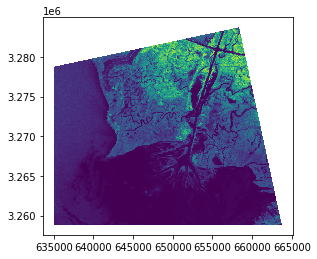

In [29]:
df_superpixels.plot(column='hh_mean')

Finally, saving the data to a shapefile.

In [33]:
df_superpixels.to_file('out/df_superpixels_with_attributes')

We can save the shapefile as GeoJSON if we don't have limits on the length of our column names.

In [31]:
#df_superpixels.to_file('out/df_superpixels_with_attributes.geojson', driver='GeoJSON')